# Image Forgery Detection (ELA and CNN)

### Name : Chow Weng Yong
### Student ID : 21 WMR 04874
### Programme : Bachelor in information security
### Year Of Study : Year 3 Sem 2

![full-architecture](relaventImage/CNN_Architecture.drawio.png "Architecture")

# Import Packages

In [1]:
# Data frames for processing data
import pandas as pd
import numpy as np

# Graphs Plotting 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

# Data Preparation before machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm

# Deep Learning package (Conv2D)
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model
import keras.utils as image
import cv2

# Initial Preparation
from PIL import Image
import os
from pylab import *
import re
from PIL import Image, ImageChops, ImageEnhance

#Tkinter
from tkinter import *
from PIL import Image,ImageTk
from tkinter.filedialog import askopenfilename

sns.set(style='white', context='notebook', palette='deep')

### Functions

In [2]:
# Retrieving all the images from a folder into a list
# Only retrieve the paths of image files 
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')]

In [3]:
def convert_to_ela_image(path, quality):
    filename = path
    resaved_filename = 'tempresaved.jpg'
    im = Image.open(filename)
    bm = im.convert('RGB')
    im.close()
    im=bm
    im.save(resaved_filename, 'JPEG', quality = quality)
    resaved_im = Image.open(resaved_filename)
    ela_im = ImageChops.difference(im, resaved_im)
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    im.close()
    bm.close()
    resaved_im.close()
    del filename
    del resaved_filename
    del im
    del bm
    del resaved_im
    del extrema
    del max_diff
    del scale
    return ela_im

In [4]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [5]:
#image size that is going to use for all images
image_size = (128, 128) 
image_Display_size = (600, 400)

### Getting the path of all image into lists and assigning label

In [8]:
# Directory of where the image stored
realDir = 'dataSets/CASIA2/Au/'
fakeDir = 'dataSets/CASIA2/Tp/'

# getting the dataSets from directory (real image), and label the data with 0 = Original
datasetReal = get_imlist(realDir)
datasetReal = pd.DataFrame(datasetReal)
label = ['label'] 
datasetReal = datasetReal.assign(**dict.fromkeys(label, 0))

# getting the dataSets from directory (fake image), and label the data with 1 = Tampered
datasetFake = get_imlist(fakeDir)
datasetFake = pd.DataFrame(datasetFake)
label = ['label'] 
datasetFake = datasetFake.assign(**dict.fromkeys(label, 1))


#Combining 2 dataSets
frames = [datasetReal, datasetFake]
dataSetsCombined = pd.concat(frames).sort_index(kind='mergesort').reset_index(drop=True)
dataSetsCombined.columns = ['fileDir', 'label']

print(f"There are total {len(dataSetsCombined)} of data.")
print(f"There are total {len(datasetReal)} of original data.")
print(f"There are total {len(datasetFake)} of tampered data.")

There are total 9418 of data.
There are total 7354 of original data.
There are total 2064 of tampered data.


### How Real Image looks like

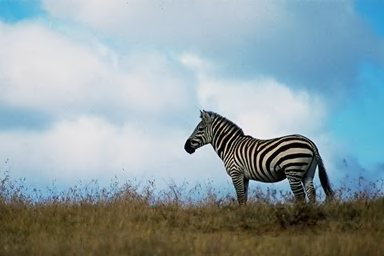

In [9]:
realImage = dataSetsCombined.fileDir[0]
# print(realImage)
Image.open(realImage)

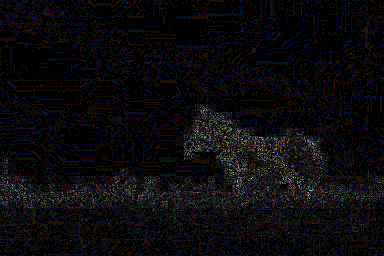

In [10]:
convert_to_ela_image(realImage, 90)

### How Fake Image looks like

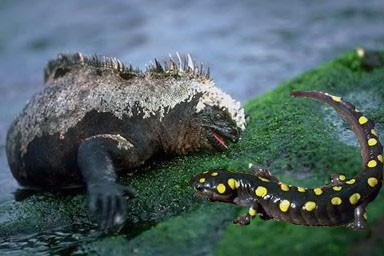

In [11]:
fakeImage = dataSetsCombined.fileDir[11]
# print(fakeImage)
Image.open(fakeImage)

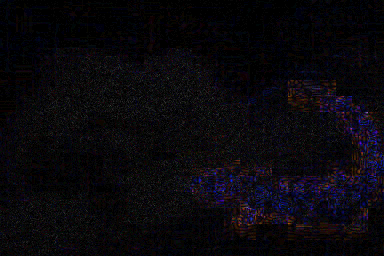

In [12]:
# Results below shows how the fake image looks like after being processing through ELA
# We can differentiate the integrity of images with human eyes by looking at the ELA image
# the ratio of ELA between two object in the image is obviosly differ from each other
# 
convert_to_ela_image(fakeImage, 90)

## Data preparation

In [22]:
X = []
Y = []

#Converting the all the image into ELA form
for index, row in dataSetsCombined.iterrows():
    X.append(prepare_image(row[0]))
    Y.append(row[1])

### Normalization

In [24]:
X = np.array(X)
Y = to_categorical(Y, 2)

In [25]:
# Uncomment the code below to see the example after the data being process
print(X)

[[0.05098039 0.03137255 0.05098039 ... 0.03921569 0.05098039 0.11764706]
 [0.02352941 0.02352941 0.01568627 ... 0.0627451  0.02745098 0.01568627]
 [0.11372549 0.05098039 0.3372549  ... 0.08235294 0.07843137 0.11372549]
 ...
 [0.18431373 0.18431373 0.18431373 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.02352941 0.04313725 0.2       ]
 [0.09019608 0.10196078 0.1372549  ... 0.10980392 0.03137255 0.03137255]]


### Reshape X

In [14]:
# Reshaping the array into a particular dimentional
X = X.reshape(-1, 128, 128, 3)

In [15]:
# Uncomment the code below to see the example after the data being process
# print(X)

## Train-test split

In [16]:
# Splitting the datasets with the ratio of 8:2, 80% for the training the model ,while 20% for testing
# This ratio is valid by the world wide because it can prevent the model from overfitting(Too smart) or underfitting(Too dumb)
# While ratio of 70:30 is acceptable at the same time
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

## CNN building

In [17]:
# Defining CNN model
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu', input_shape = (128,128,3)))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu'))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.25))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "sigmoid"))

Input:  (None, 128, 128, 3)
Output:  (None, 124, 124, 32)
Input:  (None, 128, 128, 3)
Output:  (None, 120, 120, 32)
Input:  (None, 128, 128, 3)
Output:  (None, 60, 60, 32)


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dense (Dense)               (None, 256)               29491456  
                                                        

### Add optimizer

In [19]:
optimizer = RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)


F:\Anaconda\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [20]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


### Define early stopping

In [21]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=50,
                              verbose=1, mode='min')

### Model training

In [22]:
epochs = 30
batch_size = 100

In [23]:
# Steps where the model begin learning
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_val, Y_val), verbose = 2, callbacks=[early_stopping])

Epoch 1/30
76/76 - 302s - loss: 0.4010 - accuracy: 0.7851 - val_loss: 0.3748 - val_accuracy: 0.8052 - 302s/epoch - 4s/step
Epoch 2/30
76/76 - 299s - loss: 0.2925 - accuracy: 0.8651 - val_loss: 0.2455 - val_accuracy: 0.8901 - 299s/epoch - 4s/step
Epoch 3/30
76/76 - 298s - loss: 0.2253 - accuracy: 0.9063 - val_loss: 0.1953 - val_accuracy: 0.9209 - 298s/epoch - 4s/step
Epoch 4/30
76/76 - 300s - loss: 0.2018 - accuracy: 0.9161 - val_loss: 0.1691 - val_accuracy: 0.9220 - 300s/epoch - 4s/step
Epoch 5/30
76/76 - 301s - loss: 0.1799 - accuracy: 0.9249 - val_loss: 0.1741 - val_accuracy: 0.9257 - 301s/epoch - 4s/step
Epoch 6/30
76/76 - 302s - loss: 0.1661 - accuracy: 0.9330 - val_loss: 0.1639 - val_accuracy: 0.9246 - 302s/epoch - 4s/step
Epoch 7/30
76/76 - 302s - loss: 0.1581 - accuracy: 0.9400 - val_loss: 0.1611 - val_accuracy: 0.9262 - 302s/epoch - 4s/step
Epoch 8/30
76/76 - 302s - loss: 0.1358 - accuracy: 0.9497 - val_loss: 0.1598 - val_accuracy: 0.9321 - 302s/epoch - 4s/step
Epoch 9/30
76/76

In [24]:
#save the model 
#loss: 0.1188 - accuracy: 0.9591 - val_loss: 0.1551 - val_accuracy: 0.9331
#Best accuracy = 0.9591
model.save('model.cnn')

INFO:tensorflow:Assets written to: model.cnn\assets


INFO:tensorflow:Assets written to: model.cnn\assets


## Performance measure

### Accuracy and loss curves during training-validation

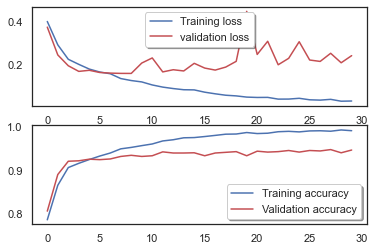

In [25]:
# Plot the loss and accuracy curves for training and testing 
# The lower the training loss, the better the machine learnt
# the higher the training accuracy, the better the machine learnt
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Confusion matrix

59/59 [==============================] - 14s 241ms/step
range(0, 2)


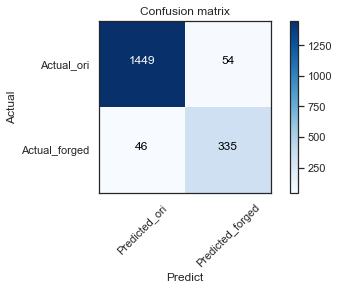

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    
    x_axisLabel = ['Predicted_ori', 'Predicted_forged']
    y_axisLabel = ['Actual_ori', 'Actual_forged']
    plt.xticks(tick_marks, x_axisLabel, rotation=45)
    plt.yticks(tick_marks, y_axisLabel)
    print(classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predict')
    
    

    
# Predict the values from the testing dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

# Prediction on new data

In [13]:
# Lad the model that is trained in advanced
model = load_model('model.cnn')
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Otput text
classes_names = ['Original', 'Forged']

In [14]:
image_path = 'dataSets/CASIA2/Au/Au_ani_00001.jpg'

# Process the new input
preparedImage = prepare_image(image_path)
preparedImage = preparedImage.reshape(-1, 128, 128, 3)

# Predict images
siag = model.predict(preparedImage)
siag_classes = np.argmax(siag, axis = 1)[0]
print(f'Result: {classes_names[siag_classes]}, Confidence: {np.amax(siag) * 100:0.2f}')


1/1 [==============================] - 3s 3s/step
Result: Original, Confidence: 100.00


In [13]:
#run the code below if the package of cv2 is not workable
# pip install opencv-python

# Creating UI

In [15]:
classes_names = ['Original', 'Forged']

In [16]:
# function for UI

# function for displaying image
def show_image(imagefile):
    image = ImageTk.PhotoImage(file=imagefile)
    imageLabel.config(image=image)
    imageLabel.image = image # save a reference of the image to avoid garbage collection
    
# function for open file
def openFile():
    Tk().withdraw()
    filename = askopenfilename()
    message.config(text = "")
    
    # Validating on file type
    if(filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.tif') or filename.endswith('.jfif')or filename.endswith('.jpeg')):
        
        # Resave the image for predicitng
        newFileName = "inputImage.jpg"
        im = Image.open(filename).resize(image_size)
        im = im.convert('RGB')
        im.save(newFileName, 'JPEG')
        
        # Resave the image for displaying
        newDisplayImage = "newDisplayImage.jpg"
        dIm = Image.open(filename).resize(image_Display_size)
        dIm = dIm.convert('RGB')
        dIm.save(newDisplayImage, 'JPEG')
        
        show_image(newDisplayImage)
        functionButton.config(text = "Scan Image", command=lambda: scanImage(filename))
    else:
        # Validation message
        message.config(text = "Invalid file type", fg ='red')

# Predict images
def scanImage(newFileName):
    # Prepared the image
    preparedImage = prepare_image(newFileName)
    preparedImage = preparedImage.reshape(-1, 128, 128, 3)
    
    # Predict the image
    siag = model.predict(preparedImage)
    siag_classes = np.argmax(siag, axis = 1)[0]
    result = (f'Result: {classes_names[siag_classes]}, Confidence Level: {np.amax(siag) * 100:0.2f}')
    
    # If the predicted result is Original then the output will be displayed in green
    # If the predicted result is Forged then the output will be displayed in red
    if siag_classes == 0:
        message.config(fg ='green')
    else:
        message.config(fg ='red')
    message.config(text = result)
    functionButton.config(text = "Select Image", command=lambda: openFile())

#quiting from the windows
def quit_me():
    root.quit()
    root.destroy()

In [17]:
root = Tk()
root.configure(bg='black')
root.title('Image Forgery Detection')

#for heading
heading = Label(root,  text="Image Forgery Detection", font=('Helvetica 16 bold'), bg='black', fg ='white')
heading.grid(row = 1, column = 3, columnspan = 6, pady = 2)

#for image
imageDisplayed = Image.open("relaventImage/systemPoster.jpeg")
imageDisplayed = ImageTk.PhotoImage(imageDisplayed)
imageLabel = Label(root, image = imageDisplayed)
imageLabel.image = imageDisplayed
imageLabel.grid(row = 2, column = 3, rowspan = 2, columnspan = 6, pady = 3)

#for messages(validation, result)
message = Label(root,  text="", font=('Helvetica 12 bold'), bg='black')
message.grid(row = 4, column = 3, columnspan = 6, pady = 3)

#for quit button
quitButton = Button(root, text='Stop', width=25, command=lambda: quit_me(), fg ='red', font = ('Helvetica 12 bold'))
quitButton.grid(row = 5, column = 3, columnspan = 3,pady = 2)

#for function button
functionButton = Button(root, text='Select Image', width=25, command=lambda: openFile(), font = ('Helvetica 12 bold'))
functionButton.grid(row = 5, column = 6, columnspan = 3, pady = 2)

root.mainloop()

1/1 [==============================] - 0s 38ms/step
